# K-Means clustering

Here we'll explore **K Means Clustering**, which is an unsupervised clustering technique.

We'll start with our standard set of initial imports

In [1]:
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## Introducing K-Means

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

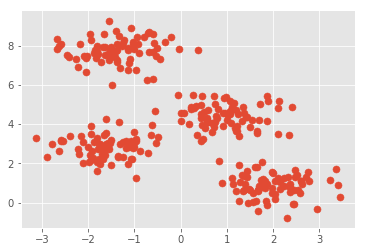

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly.

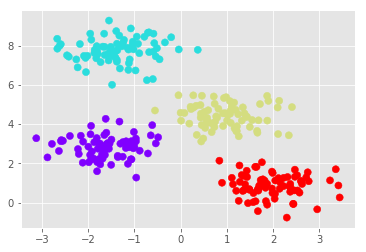

In [3]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow')
plt.show()

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged
   A. Assign points to the nearest cluster center
   B. Set the cluster centers to the mean 
   
Let's quickly visualize this process:

In [4]:
from figures import plot_kmeans_interactive
plot_kmeans_interactive();

/home/fabian/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


A Jupyter Widget

This algorithm will (often) converge to the optimal cluster centers.

### KMeans Caveats

The convergence of this algorithm is not guaranteed; for that reason, scikit-learn by default uses a large number of random initializations and finds the best results.

Also, the number of clusters must be set beforehand... there are other clustering algorithms for which this requirement may be lifted.

## Application of KMeans to Digits

For a closer-to-real-world example, let's again take a look at the digits data. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()

In [6]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

We see ten clusters in 64 dimensions. Let's visualize each of these cluster centers to see what they represent:

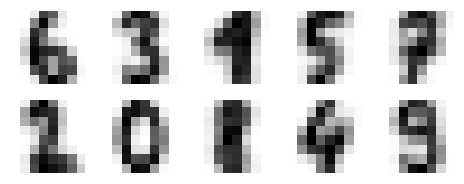

In [7]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8)!

The cluster labels are permuted; let's fix this:

In [8]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

For good measure, let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

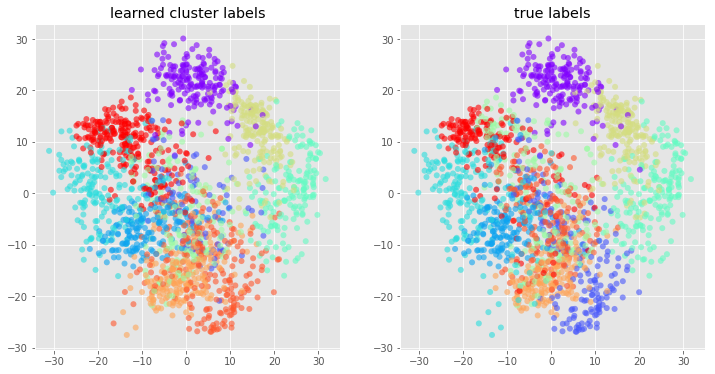

In [9]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels')
plt.show()

Just for kicks, let's see how accurate our K-Means classifier is **with no label information:**

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.79187534780189206

80% – not bad for an **entirely unsupervised estimator** which knew nothing about the labels!.

## Example: KMeans for Color Compression

One interesting application of clustering is in color image compression. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

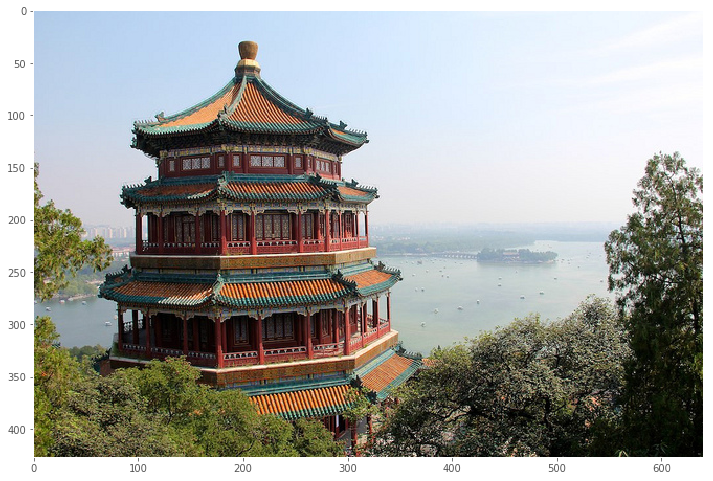

In [11]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.figure(figsize=(12,12))
plt.imshow(china)
plt.grid(False)
plt.show()

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``:

In [12]:
china.shape

(427, 640, 3)

We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [13]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


We now have 273,280 points in 3 dimensions.

Our task is to use KMeans to compress the $256^3$ colors into a smaller number (say, 64 colors). Basically, we want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

Here we'll use ``MiniBatchKMeans``, a more sophisticated estimator that performs better for larger datasets:

In [14]:
from sklearn.cluster import MiniBatchKMeans

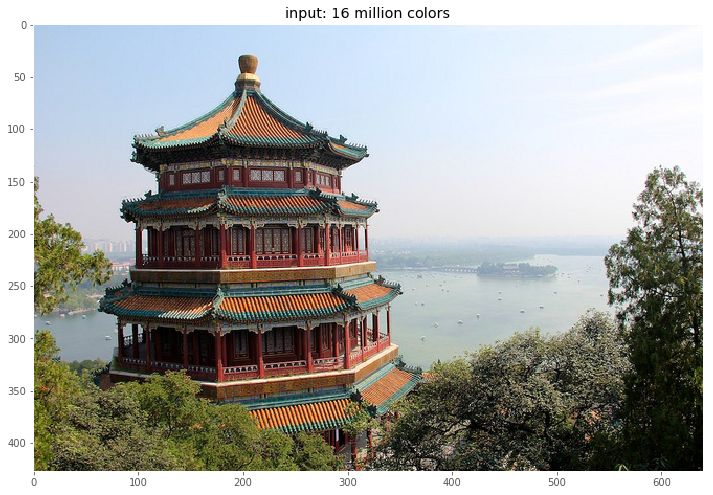

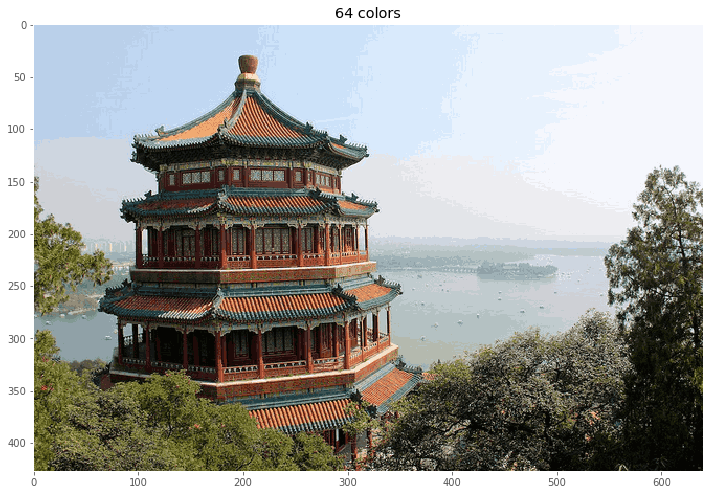

In [15]:
# reduce the size of the image for speed
n_colors = 64

X = (china / 255.0).reshape(-1, 3)
    
model = MiniBatchKMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image

plt.figure(figsize=(12,12))
plt.imshow(china)
plt.title('input: 16 million colors')
plt.grid(False)
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(new_image)
plt.grid(False)
plt.title('{0} colors'.format(n_colors))
plt.show()

Compare the input and output image: we've reduced the $256^3$ colors to just 64.

## Analysis of market structure

In this exercise we will explore the structure of the stock market, finding clusters of closely correlated companies. For each company, you get a time-series composed of the difference between the price on opening time and on closing time. 

In [16]:

import sys
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from six.moves.urllib.request import urlopen
from six.moves.urllib.parse import urlencode
from sklearn import cluster, covariance, manifold

def retry(f, n_attempts=3):
    "Wrapper function to retry function calls in case of exceptions"
    def wrapper(*args, **kwargs):
        for i in range(n_attempts):
            try:
                return f(*args, **kwargs)
            except Exception:
                if i == n_attempts - 1:
                    raise
    return wrapper


def quotes_historical_google(symbol, start_date, end_date):
    """Get the historical data from Google finance.

    Parameters
    ----------
    symbol : str
        Ticker symbol to query for, for example ``"DELL"``.
    start_date : datetime.datetime
        Start date.
    end_date : datetime.datetime
        End date.

    Returns
    -------
    X : array
        The columns are ``date`` -- date, ``open``, ``high``,
        ``low``, ``close`` and ``volume`` of type float.
    """
    params = {
        'q': symbol,
        'startdate': start_date.strftime('%Y-%m-%d'),
        'enddate': end_date.strftime('%Y-%m-%d'),
        'output': 'csv',
    }
    url = 'https://finance.google.com/finance/historical?' + urlencode(params)
    response = urlopen(url)
    dtype = {
        'names': ['date', 'open', 'high', 'low', 'close', 'volume'],
        'formats': ['object', 'f4', 'f4', 'f4', 'f4', 'f4']
    }
    converters = {
        0: lambda s: datetime.strptime(s.decode(), '%d-%b-%y').date()}
    data = np.genfromtxt(response, delimiter=',', skip_header=1,
                         dtype=dtype, converters=converters,
                         missing_values='-', filling_values=-1)
    min_date = min(data['date'], default=datetime.min.date())
    max_date = max(data['date'], default=datetime.max.date())
    start_end_diff = (end_date - start_date).days
    min_max_diff = (max_date - min_date).days
    data_is_fine = (
        start_date <= min_date <= end_date and
        start_date <= max_date <= end_date and
        start_end_diff - 7 <= min_max_diff <= start_end_diff)

    if not data_is_fine:
        message = (
            'Data looks wrong for symbol {}, url {}\n'
            '  - start_date: {}, end_date: {}\n'
            '  - min_date:   {}, max_date: {}\n'
            '  - start_end_diff: {}, min_max_diff: {}'.format(
                symbol, url,
                start_date, end_date,
                min_date, max_date,
                start_end_diff, min_max_diff))
        raise RuntimeError(message)
    return data

# #############################################################################
# Retrieve the data from Internet

# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
start_date = datetime(2003, 1, 1).date()
end_date = datetime(2008, 1, 1).date()

symbol_dict = {
    'NYSE:TOT': 'Total',
    'NYSE:XOM': 'Exxon',
    'NYSE:CVX': 'Chevron',
    'NYSE:COP': 'ConocoPhillips',
    'NYSE:VLO': 'Valero Energy',
    'NASDAQ:MSFT': 'Microsoft',
    'NYSE:IBM': 'IBM',
    'NYSE:TWX': 'Time Warner',
    'NASDAQ:CMCSA': 'Comcast',
    'NYSE:CVC': 'Cablevision',
    'NASDAQ:YHOO': 'Yahoo',
    'NASDAQ:DELL': 'Dell',
    'NYSE:HPQ': 'HP',
    'NASDAQ:AMZN': 'Amazon',
    'NYSE:TM': 'Toyota',
    'NYSE:CAJ': 'Canon',
    'NYSE:SNE': 'Sony',
    'NYSE:F': 'Ford',
    'NYSE:HMC': 'Honda',
    'NYSE:NAV': 'Navistar',
    'NYSE:NOC': 'Northrop Grumman',
    'NYSE:BA': 'Boeing',
    'NYSE:KO': 'Coca Cola',
    'NYSE:MMM': '3M',
    'NYSE:MCD': 'McDonald\'s',
    'NYSE:PEP': 'Pepsi',
    'NYSE:K': 'Kellogg',
    'NYSE:UN': 'Unilever',
    'NASDAQ:MAR': 'Marriott',
    'NYSE:PG': 'Procter Gamble',
    'NYSE:CL': 'Colgate-Palmolive',
    'NYSE:GE': 'General Electrics',
    'NYSE:WFC': 'Wells Fargo',
    'NYSE:JPM': 'JPMorgan Chase',
    'NYSE:AIG': 'AIG',
    'NYSE:AXP': 'American express',
    'NYSE:BAC': 'Bank of America',
    'NYSE:GS': 'Goldman Sachs',
    'NASDAQ:AAPL': 'Apple',
    'NYSE:SAP': 'SAP',
    'NASDAQ:CSCO': 'Cisco',
    'NASDAQ:TXN': 'Texas Instruments',
    'NYSE:XRX': 'Xerox',
    'NYSE:WMT': 'Wal-Mart',
    'NYSE:HD': 'Home Depot',
    'NYSE:GSK': 'GlaxoSmithKline',
    'NYSE:PFE': 'Pfizer',
    'NYSE:SNY': 'Sanofi-Aventis',
    'NYSE:NVS': 'Novartis',
    'NYSE:KMB': 'Kimberly-Clark',
    'NYSE:R': 'Ryder',
    'NYSE:GD': 'General Dynamics',
    'NYSE:RTN': 'Raytheon',
    'NYSE:CVS': 'CVS',
    'NYSE:CAT': 'Caterpillar',
    'NYSE:DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

# retry is used because quotes_historical_google can temporarily fail
# for various reasons (e.g. empty result from Google API).
quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    quotes.append(retry(quotes_historical_google)(
        symbol, start_date, end_date))

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices

tmp = variation.copy().T
tmp /= tmp.std(axis=0)
X = tmp.T

Fetching quote history for 'NASDAQ:AAPL'
Fetching quote history for 'NASDAQ:AMZN'
Fetching quote history for 'NASDAQ:CMCSA'
Fetching quote history for 'NASDAQ:CSCO'
Fetching quote history for 'NASDAQ:DELL'
Fetching quote history for 'NASDAQ:MAR'
Fetching quote history for 'NASDAQ:MSFT'
Fetching quote history for 'NASDAQ:TXN'
Fetching quote history for 'NASDAQ:YHOO'
Fetching quote history for 'NYSE:AIG'
Fetching quote history for 'NYSE:AXP'
Fetching quote history for 'NYSE:BA'
Fetching quote history for 'NYSE:BAC'
Fetching quote history for 'NYSE:CAJ'
Fetching quote history for 'NYSE:CAT'
Fetching quote history for 'NYSE:CL'
Fetching quote history for 'NYSE:COP'
Fetching quote history for 'NYSE:CVC'
Fetching quote history for 'NYSE:CVS'
Fetching quote history for 'NYSE:CVX'
Fetching quote history for 'NYSE:DD'
Fetching quote history for 'NYSE:F'
Fetching quote history for 'NYSE:GD'
Fetching quote history for 'NYSE:GE'
Fetching quote history for 'NYSE:GS'
Fetching quote history for 'NYSE

In [17]:
# now we have the following data
# X is formed of 56 time-series
X.shape

(56, 1258)

In [18]:
names

array(['Apple', 'Amazon', 'Comcast', 'Cisco', 'Dell', 'Marriott',
       'Microsoft', 'Texas Instruments', 'Yahoo', 'AIG',
       'American express', 'Boeing', 'Bank of America', 'Canon',
       'Caterpillar', 'Colgate-Palmolive', 'ConocoPhillips', 'Cablevision',
       'CVS', 'Chevron', 'DuPont de Nemours', 'Ford', 'General Dynamics',
       'General Electrics', 'Goldman Sachs', 'GlaxoSmithKline',
       'Home Depot', 'Honda', 'HP', 'IBM', 'JPMorgan Chase', 'Kellogg',
       'Kimberly-Clark', 'Coca Cola', "McDonald's", '3M', 'Navistar',
       'Northrop Grumman', 'Novartis', 'Pepsi', 'Pfizer', 'Procter Gamble',
       'Ryder', 'Raytheon', 'SAP', 'Sony', 'Sanofi-Aventis', 'Toyota',
       'Total', 'Time Warner', 'Unilever', 'Valero Energy', 'Wells Fargo',
       'Wal-Mart', 'Exxon', 'Xerox'],
      dtype='<U17')

# Exercise

**Warm-up**. Plot the 2-dimensional PCA projection for these time series.

* Remember, the answer to the question "what should we do first?" is always visualize :-)

**Find structure**. Use a clustering algorithm to identify companies whose behaviour is similar (i.e., whose timeseries are close together). How many clusters do you observe?

**Extract insight**. What does this clustering tell us about the stock market?

**Refine**. Is your clustering algorithm the appropriate one? What about the metric? Do you need dimensionality reduction? 
